In [75]:
import glob
import re
from util import get_meta_information
from LightCurve import CRTS_VS_LightCurve

def load_data(file_name_list, GP_model=False):
    '''
    读取单个类的数据
    将原始数据读取为LightCurve对象，并进行预处理
    '''
    info_file = 'data/SSS_Per_Tab.txt'
    info = get_meta_information(info_file)
    lc_list = []
    for name in file_name_list:
        split_name = re.match(r'(data/original_data/type/)(\d{1,2})(/)(\d{11,14})(\w{0,15}).dat',name)
        class_label = split_name.group(2)
        lc = CRTS_VS_LightCurve()
        lc.class_label = class_label
        lc.read_CRTS_dat(name, id=split_name.group(4))
        period = info.loc[int(lc.id), 'Period']
        lc.fold(2 * period, normalize_phase=True, normalize_section=[0,2]) #为了展示，改为两倍周期折叠
        lc.clean()
        if GP_model == True:
            try:
                lc.fit_GP_model()
            except:
                print('there is an error when fit GP_model, class_label=%s, id=%s'%(lc.class_label,lc.id))
                lc.show()
        lc_list.append(lc)
    print('load %d files'%len(file_name_list))
    return lc_list

RRab_name_list = glob.glob('data/original_data/type/1/*.dat')
Ecl_name_list = glob.glob('data/original_data/type/5/*.dat')
EA_name_list = glob.glob('data/original_data/type/6/*.dat')
LPV_name_list = glob.glob('data/original_data/type/8/*.dat')
DS_name_list = glob.glob('data/original_data/type/9/*.dat')
ACEP_name_list = glob.glob('data/original_data/type/10/*.dat')
RRab_lc_list = load_data(RRab_name_list)
Ecl_lc_list = load_data(Ecl_name_list)
EA_lc_list = load_data(EA_name_list)
LPV_lc_list = load_data(LPV_name_list)
DS_lc_list = load_data(DS_name_list)
ACEP_lc_list = load_data(ACEP_name_list)

load 4325 files
load 18803 files
load 4509 files
load 1286 files
load 147 files
load 153 files


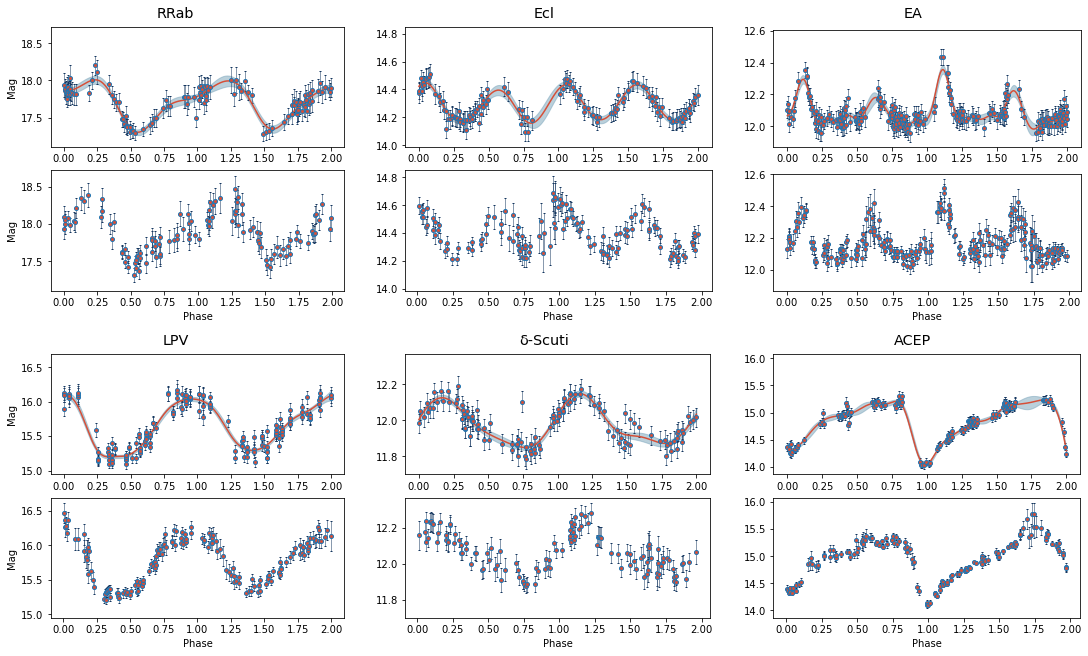

In [124]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib

fig = plt.figure(constrained_layout=True, figsize=(15, 9))
fig.set_facecolor('w')
subfigs = fig.subfigures(nrows=2, ncols=3, wspace=0.07)

def subfigure_plot(subfugs, lc, row, col, x_label=True, y_label=False, name=''):
    lc.GP_smooth()
    x = np.array(lc.data['phase'])
    y = np.array(lc.data[lc.measurement])
    err = np.array(lc.data[lc.error])
    x_pred = np.linspace(0,2,300)
    pred,pred_var = lc.GP_model.predict(y, x_pred, return_var=True)
    x_simu = np.random.uniform(low=0,high=lc.phase_span, size=len(lc))
    x_simu = np.sort(x_simu)
    simu_lc = lc.generate_GP_simulation(x_simu)
    y_simu = simu_lc.data[simu_lc.measurement]
    err_simu = simu_lc.data[simu_lc.error]

    axs = subfigs[row][col].subplots(2, 1, sharey=True)
    subfigs[row][col].set_facecolor('w')
    subfigs[row][col].suptitle(name, fontsize='x-large')
    axtop = axs[0]
    if y_label is True:
        axtop.set_ylabel('Mag')
    axtop.errorbar(x,y,err, fmt='o',ms=4, mfc=[0.839,0.31,0.22], ecolor=[0.078,0.212,0.373],elinewidth=0.5, capsize=1)
    axtop.plot(x_pred,pred,color=[0.839,0.31,0.22])
    axtop.fill_between(x_pred,pred-np.sqrt(pred_var),pred+np.sqrt(pred_var),color=[0.463,0.635,0.725], alpha=0.5)
    axbottom = axs[1]
    if x_label is True:
        axbottom.set_xlabel('Phase')
    if y_label is True:
        axbottom.set_ylabel('Mag')
    axbottom.errorbar(x_simu,y_simu,err_simu, fmt='o',ms=4, mfc=[0.839,0.31,0.22], ecolor=[0.078,0.212,0.373],elinewidth=0.5, capsize=1)

lc = RRab_lc_list[43]
subfigure_plot(subfigs, lc, 0, 0, y_label=True, name='RRab')
lc = Ecl_lc_list[7]
subfigure_plot(subfigs, lc, 0, 1, name='Ecl')
lc = EA_lc_list[2]
subfigure_plot(subfigs, lc, 0, 2, name='EA')
lc = LPV_lc_list[8]
subfigure_plot(subfigs, lc, 1, 0, x_label=True, y_label=True, name='LPV')
lc = DS_lc_list[134]
subfigure_plot(subfigs, lc, 1, 1, x_label=True, name='δ-Scuti')
lc = ACEP_lc_list[2]
subfigure_plot(subfigs, lc, 1, 2, x_label=True, name='ACEP')

# [0.973,0.95,0.922]
plt.show()